In [18]:
import numpy as np
from time import time
import scipy.sparse as sps
from sklearn.preprocessing import normalize
from scipy import sparse
from scipy.sparse.linalg import svds
from sklearn import datasets
import matplotlib.pyplot as plt

In [19]:
V = 281903
E = 2312497

In [20]:
data = np.genfromtxt('web-Stanford.txt', dtype=[('FromNodeId', np.intp),
                                        ('ToNodeId', np.intp)])
P = sps.csr_matrix((np.ones(len(data)), (data['FromNodeId']-1, data['ToNodeId']-1)))
#P += sps.identity(P.shape[0])
P = normalize(P, axis=0, norm='l1')

In [21]:
A = sps.identity(P.shape[0]) - P.T - P + P.T@P

In [23]:
def CalculatePartialGradient(w, i):
    
    grad = sparse.csr_matrix(([1], ([i], [0])), shape=(V, 1))
    coeff = 2 * A[i].dot(w)
    return grad.dot(coeff) * V

def CalculateGradient(w):
    return 2 * A.dot(w)
    
def DoLinOpt(vect):
    j = vect.argmin()
    return sparse.csr_matrix(([1], ([j], [0])), shape=(V, 1))

def CalculateVarRedSG(w, full_grad, w_0):
    rand_ind = np.random.randint(0, V)
    return CalculatePartialGradient(w, rand_ind) -\
            (CalculatePartialGradient(w_0, rand_ind) - full_grad)

def GetGamma(k):
    return 0.1 / (k + 2)

def GetM(k):
    return 50

def GetN(t):
    return 25

def CalcLoss(w):
    return w.transpose().dot(A.dot(w)) 

def DoSVRF(T, start_time, times):
    w = []
    x_init = sparse.csr_matrix(([1 / V for i in range(V)], ([i for i in range(V)], [0 for i in range(V)])), shape=(V, 1))
    full_grad = CalculateGradient(x_init)
    w += [DoLinOpt(full_grad)]
    for t in range(T):
        x = []
        x += [w[-1]]
        full_grad = CalculateGradient(x[0])
        for k in range(GetN(t)):
            if k != 0:
                sum_grads = x_init
                for i in range(GetM(k)):
                    sum_grads += CalculateVarRedSG(x[-1], full_grad, x[0])
                curr_grad = sum_grads / GetM(k)
            else:
                curr_grad = full_grad
            
            v = DoLinOpt(curr_grad)
            gamma = GetGamma(k)
            x += [(1 - gamma) * x[-1] + gamma * v]
            w += [x[-1]]
            times.append(round(time() - start_time, 2))
    return w, times

In [24]:
times = [0]
start_time = time()
seq, times = DoSVRF(5, start_time, times)
vals = [CalcLoss(w) for w in seq]
vals = [val.toarray()[0][0] for val in vals]

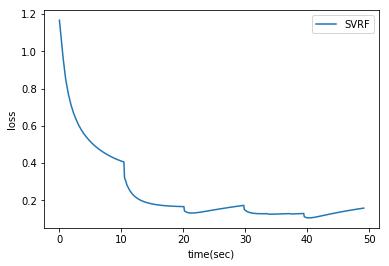

In [27]:
plt.plot(times, vals, label = 'SVRF')
plt.xlabel('time(sec)')
plt.ylabel('loss')
plt.legend()
plt.show()

In [26]:
np.save('pagerank/losses_SVRF', np.array(vals))
np.save('pagerank/times_SVRF', np.array(times))